In [1]:
import tensorflow as tf 
%matplotlib inline
import numpy as np
import datasched as ds
%matplotlib inline
tf.__version__

'2.1.0'

# `ScheduleDataset` class

combines several datasets according to weights. Same functionality as [tf.data.experimental.sample_from_datasets](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets), but weights are internally represented as tensors so that they are part of the computational graph and can be changed during training with `ScheduleDataset_Callback` as explained further below.

for instance, combining MNIST train and test data in an 80/20 proportion with different batch sizes (not sure what this could be useful for :-), other than distinguishing the original dataset in the final mixture)

In [2]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

fmnist_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
fmnist_test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

di = ds.ScheduleDataset([fmnist_train_ds.batch(64).repeat(-1), fmnist_test_ds.batch(32).repeat(-1)], [.8, .2])

for k,_ in zip(di, range(10)):
    print (k[0].numpy().shape, k[1].numpy().shape[0])


(64, 784) 64
(64, 784) 64
(64, 784) 64
(64, 784) 64
(64, 784) 64
(64, 784) 64
(64, 784) 64
(32, 784) 32
(32, 784) 32
(64, 784) 64


observe how proportions are kept

In [3]:
d0 = tf.data.Dataset.from_tensor_slices([0]).repeat(-1)
d1 = tf.data.Dataset.from_tensor_slices([1]).repeat(-1)

di = ds.ScheduleDataset([d0, d1], weights=[.35,.65])

k = np.r_[[i.numpy() for i,_ in zip(di, range(10000))]]
np.mean(k==0), np.mean(k==1)

(0.3561, 0.6439)

if you **don't use `repeat(-1)`**, when either dataset is exhausted then you will only get elements of the one still producing them, so you may observe different proportions from the ones specified in `weights`

In [4]:
d0 = tf.data.Dataset.from_tensor_slices([0]).repeat(1000)
d1 = tf.data.Dataset.from_tensor_slices([1]).repeat(-1)

di = ds.ScheduleDataset([d0, d1], weights=[.35,.65])

k = np.r_[[i.numpy() for i,_ in zip(di, range(10000))]]
np.mean(k==0), np.mean(k==1)

(0.1, 0.9)

# `ScheduleDataset_Callback` class

if we want the class weights to change during training we need to

- use an instance of `ScheduleDataset_Callback` class
- specify a function that will be called at every training step and must return a set of weights
- include the instance on the fit callbacks
- if we specify a keras.tensorboard callback, then the schedule will also be logged to TensorBoard

There are several predefined functions, 

In [5]:
ds.ScheduleDataset_Callback.get_available_funcs().keys()

dict_keys(['linear', 'log', 'sin', 'sin2', 'sin4', 'sin10', 'sqr', 'sqrt'])

and they simply return a weight vector depending on the current epoch and step (batch number). For instance,

In [6]:
from inspect import getsource
print (getsource(ds.ScheduleDataset_Callback.linear_dataschedule_fn))

    @staticmethod
    def linear_dataschedule_fn(ds_callback):
        epochs = ds_callback.params["epochs"]
        current_epoch = ds_callback.current_epoch

        p1 = current_epoch / epochs 
        return [p1, 1-p1]        



**before training**, you can see how a data schedule would be, depending on how many epoch (and maybe training steps) your training will have

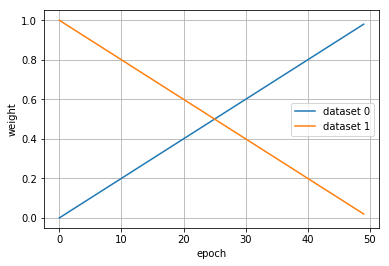

In [7]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="linear")

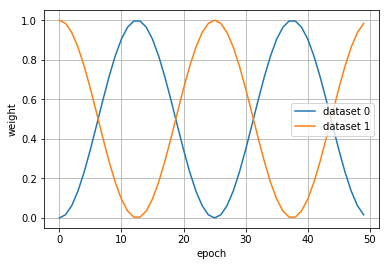

In [8]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="sin2")

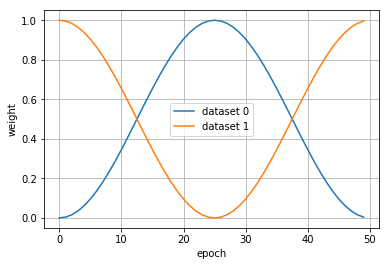

In [9]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="sin")

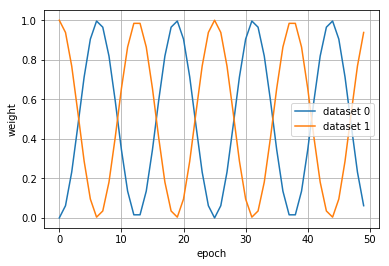

In [10]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="sin4")

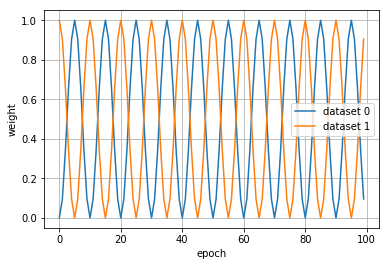

In [22]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=100, steps_per_epoch=30, dataset_weights_fn="sin10")

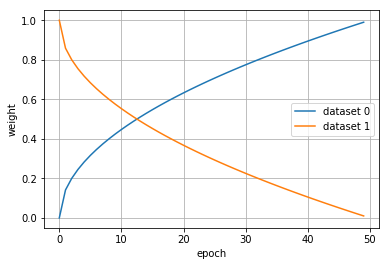

In [12]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="sqrt")

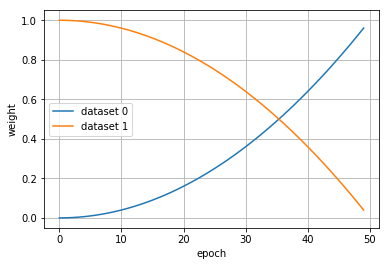

In [13]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="sqr")

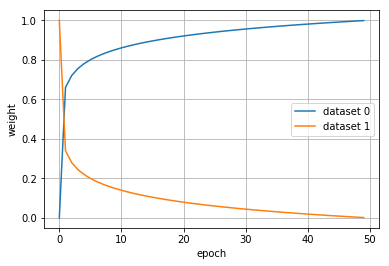

In [14]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, dataset_weights_fn="log")

### using a data schedule for training

You have to:

1. Create a `ScheduleDataset` instance with your initial datasets. It is ok not to specify weights, since they will be set during training.
2. Create a `tf.keras.callbacks.TensorBoard` if you want to log training to TensorBoard (optional)
3. Create a `ScheduleDataset_Callback` instance referring to the previous two.
4. Use accordingly the three objects in your fit method.

See the code below, and open tensorboard to see the train logs and the data schedule used

In [15]:
di = ds.ScheduleDataset([fmnist_train_ds.batch(64).repeat(-1), fmnist_test_ds.batch(64).repeat(-1)],
                         datasets_names=["MNIST train", "MNIST test"])


In [16]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(50, activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
    model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [17]:
!rm -rf mlog

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="mlog")

cb = ds.ScheduleDataset_Callback(di, dataset_weights_fn="sin2", 
                                     keras_tensorboard_callback=tensorboard_callback)

model = get_model()
_ = model.fit(di, epochs=40, steps_per_epoch=30, verbose=1, 
              callbacks=[cb, tensorboard_callback])


Train for 30 steps
Epoch 1/40
30/30 [==============================] - 0s 15ms/step - loss: 2.1548 - accuracy: 0.4646
Epoch 2/40
30/30 [==============================] - 0s 2ms/step - loss: 1.8908 - accuracy: 0.7448
Epoch 3/40
30/30 [==============================] - 0s 2ms/step - loss: 1.7500 - accuracy: 0.8016
Epoch 4/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6917 - accuracy: 0.8479
Epoch 5/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6476 - accuracy: 0.8734
Epoch 6/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6485 - accuracy: 0.8681
Epoch 7/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6397 - accuracy: 0.8687
Epoch 8/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6390 - accuracy: 0.8703
Epoch 9/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6238 - accuracy: 0.8844
Epoch 10/40
30/30 [==============================] - 0s 2ms/step - loss: 1.6139 - accuracy: 0.8760

## defining your own data schedule

simply create your function, following any of the examples in the ones already predefined.

**use `plot_schedule`** to see how your data schedule would look like before training.

observe that the `ds_callback` object passed as argument is an instance of `ScheduleDataset_Callback` which inherits from `tf.keras.callbacks.Callback`, so that logs, metrics, etc. should be available for your logic. For instance, the `params` dictionary usually contains the parameters with which `fit` was called.

your function will be called at the beginning of each epoch

In [18]:
print (getsource(ds.ScheduleDataset_Callback.sqr_dataschedule_fn))

    @staticmethod
    def sqr_dataschedule_fn(ds_callback):
        epochs = ds_callback.params["epochs"]
        current_epoch = ds_callback.current_epoch

        p1 = current_epoch / epochs 
        p1 = p1**2
        return [p1, 1-p1]



In [19]:
print (getsource(ds.ScheduleDataset_Callback.log_dataschedule_fn))

    @staticmethod
    def log_dataschedule_fn(ds_callback):
        epochs = ds_callback.params["epochs"]
        current_epoch = ds_callback.current_epoch

        p1 = current_epoch / epochs 
        p1 = 1e-5 if p1<=1e-5 else p1
        p1 = np.log(p1)
        p1 = (p1-np.log(1e-5))/(-np.log(1e-5))
        return [p1, 1-p1]



In [20]:
def myweird_dataschedule_fn(ds_callback):
    epochs = ds_callback.params["epochs"]
    current_epoch = ds_callback.current_epoch

    p1 = current_epoch / epochs
    p1 = p1 * np.cos(8*p1)**2
    return [p1, 1-p1] 

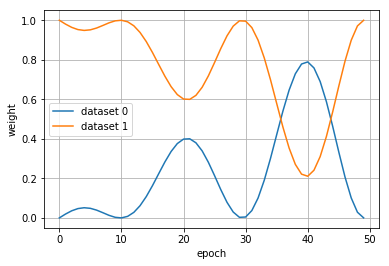

In [21]:
ds.ScheduleDataset_Callback.plot_schedule(n_epochs=50, steps_per_epoch=30, 
                                          dataset_weights_fn=myweird_dataschedule_fn)